## Factors in Meteorite Distribution

Meteorites are often found in deserts or areas with low vegetation. After making several maps visualizing meteorite landing data, and seeing a correlation between vegetation and the locations meteorites are found, I sought to quantify this relationship. This Jupyter notebook does so by comparing a [Nasa data set of discovered meteorites](https://data.nasa.gov/Space-Science/Meteorite-Landings/gh4g-9sfh/data), as of 2013, and [global vegetation](https://github.com/globalmaps/gm_ve_v2), measured using MODIS. 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/JGCAITLIN/final_project_21/HEAD)

## Import libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import xarray as xr
from osgeo import gdal
import glob
import rioxarray

## Reading and cleaning meteorite data

In [2]:
# reading data
df = pd.read_csv('Meteorite_Landings.csv') 

In [3]:
# cleaning up data
df = df.rename(columns={"mass (g)": "mass_g", "recclass": "group"})#renaming some column names
df = df[(df.nametype == 'Valid')]                                  #removing highly altered meteorites


no_location   = (df.reclat == 0) & (df.reclong == 0)               #replacing (0,0) locations with nans              
df['reclat']  = df['reclat'].mask(no_location)
df['reclong'] = df['reclong'].mask(no_location)


df["year"]  = [pd.Period(d, freq="Y").year for d in df.year]        #reducing year column to year only
faulty_year = df.year > 2022
df['year']  = df['year'].mask(faulty_year)                          #replacing faulty years with nans

df.set_index('name', inplace=True)                                  #setting index to meteorite name
df.head()

,id,nametype,group,mass_g,fall,year,reclat,reclong,GeoLocation
name,,,,,,,,,
Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"


Let's do a visual check to see how everything is looking. I'm choosing to look at finds vs falls here just to make the plot a bit more interesting.

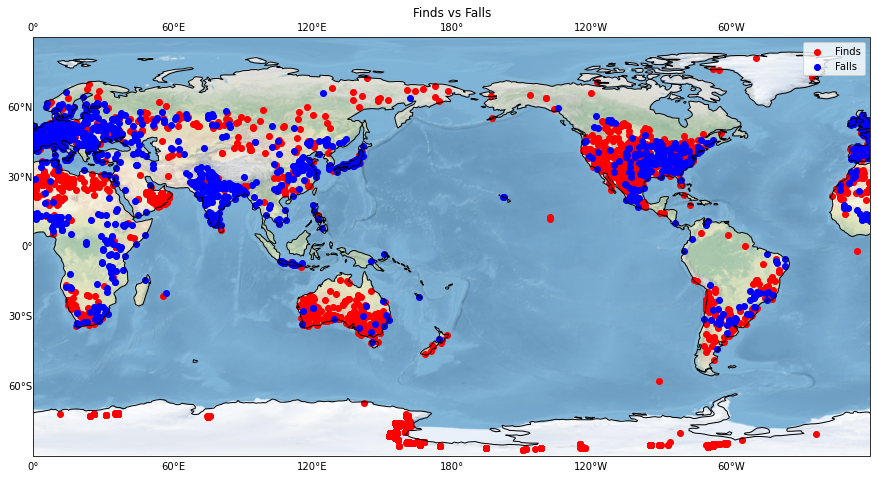

In [4]:
#map showing falls vs finds
df_found = df[df.fall == 'Found']
df_fell  = df[df.fall == 'Fell']

fig= plt.figure(figsize=(15, 8))
proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=proj)

ax.coastlines()
ax.stock_img()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)

plot = ax.scatter(df_found.reclong, df_found.reclat, c='r', transform=ccrs.PlateCarree(), label='Finds')
plot = ax.scatter(df_fell.reclong, df_fell.reclat, c='b', transform=ccrs.PlateCarree(), label='Falls')
ax.set_title('Finds vs Falls')
ax.legend();

Note, in antarctica, there are only finds because there is no one there to observe the meteorites fall!

## Importing, merging, and cleaning vegetation tifs

Now that the meteorite data is ready to use, I can work on tidying the vegetation data. The global vegetation data comes in twelve seperate tiles that I will stitch together using gdal.

In [5]:
all_tifs = glob.glob('gm_ve_v2_[0-9]_[0-9].tif') #reading all 12 tiles 
print(all_tifs)                                  #checking they're all here

['gm_ve_v2_1_4.tif', 'gm_ve_v2_1_1.tif', 'gm_ve_v2_2_6.tif', 'gm_ve_v2_2_2.tif', 'gm_ve_v2_2_5.tif', 'gm_ve_v2_1_6.tif', 'gm_ve_v2_2_1.tif', 'gm_ve_v2_2_3.tif', 'gm_ve_v2_1_5.tif', 'gm_ve_v2_2_4.tif', 'gm_ve_v2_1_3.tif', 'gm_ve_v2_1_2.tif']


In [6]:
vrt = gdal.BuildVRT('merged.vrt', all_tifs)
gdal.Translate('merged_lowres.tif', vrt, xRes = 0.5, yRes = -0.5) #merging the tiles into a single tif with resolution- longitude= 0.5 deg., latitude=0.5 deg.
vrt = None

In [7]:
#reading in vegetation tif
veg_raw    = xr.open_dataset('merged_lowres.tif')                #putting veg. data into a dataset and setting some parameters
veg_raw    = veg_raw.set_coords(['x', 'y'])
veg_raw    = veg_raw.rename({"band_data": "percent_tree_cover"})
veg_masked = veg_raw.where(veg_raw['percent_tree_cover'] <= 100) #masking out bodies of water and areas with no data, marked with values of 254 and 255
veg_masked

<xarray.Dataset>
Dimensions:             (band: 1, y: 360, x: 720)
Coordinates:
  * band                (band) int64 1
  * x                   (x) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * y                   (y) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
    spatial_ref         int64 0
Data variables:
    percent_tree_cover  (band, y, x) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0

Let's also check this data looks appropriate.

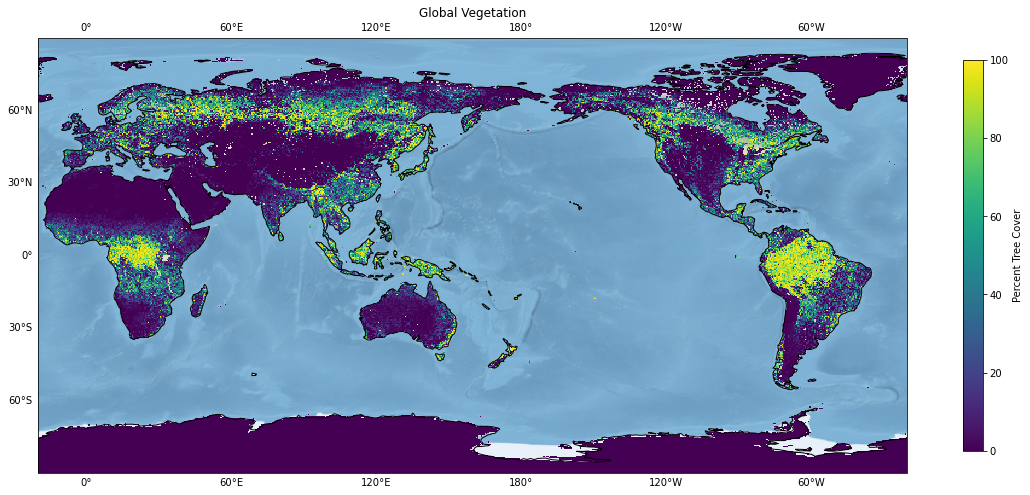

In [8]:
fig= plt.figure(figsize=(20, 8))
proj = ccrs.PlateCarree(central_longitude=160)
ax = plt.axes(projection=proj)

ax.coastlines()
ax.stock_img()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)

vegetation    = veg_masked['percent_tree_cover'].plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
vegetation_cb = plt.colorbar(vegetation, ax=ax, location='right', label='Percent Tree Cover', shrink=0.9)
ax.set_title('Global Vegetation');

## Visualizing vegetation and meteorite data

Now that both datasets are ready, we can see what they look like together!

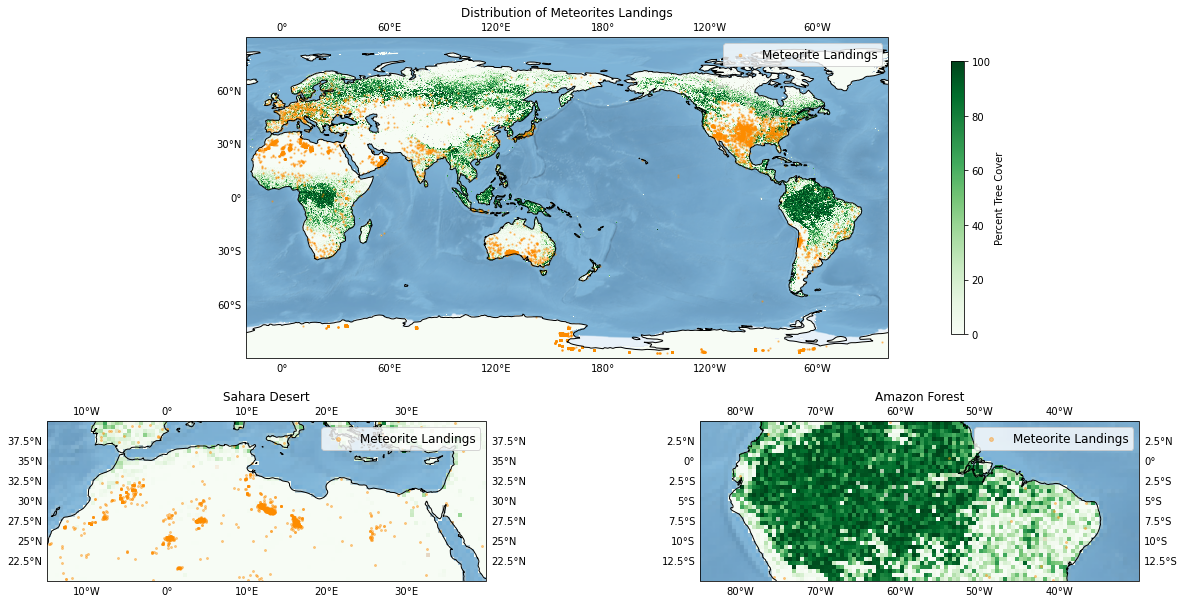

In [9]:
#setting up figure and adding subplots
fig  = plt.figure(figsize=(20, 10))
proj = ccrs.PlateCarree(central_longitude=160)

gs = fig.add_gridspec(8,9)
ax1 = fig.add_subplot(gs[0:4, :8], projection=proj)
ax2 = fig.add_subplot(gs[3:, 1:4], projection=proj)
ax3 = fig.add_subplot(gs[3:, 5:8], projection=proj)

#global plot
ax1.coastlines()
ax1.stock_img()
ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)

vegetation = veg_masked['percent_tree_cover'].plot(ax=ax1, cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False)
veg_cb     = plt.colorbar(vegetation, ax=ax1, location='right', label='Percent Tree Cover', shrink=.85)#, aspect=.5)

meteorites = ax1.scatter(df.reclong, df.reclat, c='darkorange', marker='.', label='Meteorite Landings', alpha=0.4, transform=ccrs.PlateCarree(), s=7)
ax1.legend(loc='upper right', prop={'size': 12}, markerscale=2)

#sahara subplot
veg_sahara = veg_masked.rio.clip_box(minx=-15, miny=20, maxx=40, maxy=40)
vegetation_sahara = veg_sahara['percent_tree_cover'].plot(ax=ax2, cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False)

met_sahara = df[(df.reclong>=-15) & (df.reclong<=40) & (df.reclat<=40) & (df.reclat>=20)]
meteorites_sahara = ax2.scatter(met_sahara.reclong, met_sahara.reclat, c='darkorange', marker='.', label='Meteorite Landings', alpha=0.4, transform=ccrs.PlateCarree(), s=15)
ax2.legend(loc='upper right', prop={'size': 12}, markerscale=2)

ax2.coastlines()
ax2.stock_img()
ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)


#amazon subplot
veg_amazon = veg_masked.rio.clip_box(minx=-85, miny=-15, maxx=-30, maxy=5)
vegetation_amazon = veg_amazon['percent_tree_cover'].plot(ax=ax3, cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False)

met_amazon = df[(df.reclong>=-85) & (df.reclong<=-30) & (df.reclat<=5) & (df.reclat>=-15)]
meteorites_sahara = ax3.scatter(met_amazon.reclong, met_amazon.reclat, c='darkorange', marker='.', label='Meteorite Landings', alpha=0.4, transform=ccrs.PlateCarree(), s=15)
ax3.legend(loc='upper right', prop={'size': 12}, markerscale=2)

ax3.coastlines()
ax3.stock_img()
ax3.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)

#setting title
ax1.set_title('Distribution of Meteorites Landings')
ax2.set_title('Sahara Desert')
ax3.set_title('Amazon Forest')
fig.tight_layout();


Along with a global map, I include both a low and high vegetation region to more clearly see meteorite landings in those distinct regions. I set the meteorite markers to be slightly transparent to give some indication to where more meteorites are found, but it is still hard to distiguish where the highest density cases are located. For example, based on this figure, it may seem that the highest density of meteorites-found is located the mid-USA, but we will soon find out that this is not the case.

## Comparing tree cover vs meteorite landings

To compare the meteorite landings to vegetation I need to use a grid over the entirety of both datasets. This is very straightforward for the vegitation data because it is already in a gridded format. For this, I will take the mean over 5 element x 5 element boxes using xarray's coarsen. 

In [10]:
veg_mean = veg_masked.coarsen(x=5, y=5).mean()

Because the meteorite data is not in a similar format, I will need to loop through the grid and count the number of meteorites in each gridbox. The issue with using the coarsen function, as above, is that each box begins with the next element in line rather than the last elment from the previous box. For example, in the case of my 5 element 'window', the second gridbox begins with element number 6, not number 5. Because of this, when calculating meteorite counts, I will extend the meteorite gridboxes to the midpoints between the vegetation gridboxes.

In [11]:
met_count = np.zeros((len(veg_mean.y.values), len(veg_mean.x.values))) #creating empty array to fill 
window    = 5                                                          #setting the window size to the same number of elements as the vegetation data
element_distance = veg_masked.x.values[1] - veg_masked.x.values[0]     #calculating the dastance between two elements

for i in range(0, len(veg_masked.x.values), window):                   #setting left and right edges of gridboxes
    
    
    if i == 0:                                                         #edge case
        left = veg_masked.x.values[i]
        right = veg_masked.x.values[i+window-1] + (element_distance/2)
    
    if i == (len(veg_masked.x.values)-window):                         #edge case
        left  = veg_masked.x.values[i] - (element_distance/2)
        right = veg_masked.x.values[i+window-1]
        
    else: 
        left  = veg_masked.x.values[i] - (element_distance/2)
        right = veg_masked.x.values[i+window-1] + (element_distance/2)
        

    for j in range (0, len(veg_masked.y.values), window):              #setting top and bottom edges of gridboxes
        
        if j == 0:                                                     #edge case
            top    = veg_masked.y.values[j]
            bottom = veg_masked.y.values[j+window-1] - (element_distance/2)
            
        if j == (len(veg_masked.y.values)-window):                     #edge case
            top    = veg_masked.y.values[j] + (element_distance/2)
            bottom = veg_masked.y.values[j+window-1]
            
        else:
            top    = veg_masked.y.values[j] + (element_distance/2) 
            bottom = veg_masked.y.values[j+window-1] - (element_distance/2)

        
        count = df[(df.reclong>=left) & (df.reclong<right) & (df.reclat<=top) & (df.reclat>bottom)].id.count() #I include the the top and left sides of the box for meteorites that lie on edges 
        met_count[int(j/window), int(i/window)] = count #putting the values in the correct position

To directly compare both calculations I will flatten each array and plot.

In [12]:
met_count_flat = met_count.flatten()
veg_mean_flat  = veg_mean.percent_tree_cover.values[0, :, :].flatten()

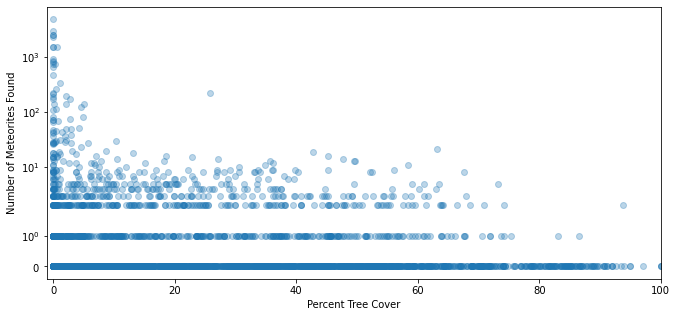

In [13]:
fig, ax = plt.subplots(figsize=(11, 5))
ax.scatter(veg_mean_flat, met_count_flat, alpha=0.3) 
ax.set_yscale('symlog')
ax.set_xlim(-1, 100)
#ax.set_ylim(0, 6000)
ax.set_xlabel('Percent Tree Cover')
ax.set_ylabel('Number of Meteorites Found');

This figure gives some indication that there is a correlation between vegetation and number of meteorites found. As you can see, gridboxes with a higher meteorite count tend to fall in regions with lower vegetation, but, based on the gridboxes containg zero meteorites, there also seems to be more boxes that have lower vegetation means in general. Because of this, further quantitatve analysis is required. For this, I will put both the vegetation array and the meteorite array into a dataframe. Using this dataframe I can group both datasets by bins based on percent tree cover and look at the count of gridboxes, the mean number of meteorites found, and the total number of meteorites found in each bin.   

In [14]:
# putting vegetaion and meteorite counts in same dataframe to compare
data = {
'meteorites': met_count_flat,
'vegetation': veg_mean_flat
}

df_final = pd.DataFrame(data)
df_final = df_final.dropna()

In [15]:
#grouping data based on percent tree cover
bin_labels= ['[0-5%]', '(5-10%]', '(10-15%]', '(15-20%]', '(20-25%]', '(25-30%]', '(30-35%]', '(35-40%]', '(40-45%]', '(45-50%]', '(50-55%]',
            '(55-60%]', '(60-65%]', '(65-70%]', '(70-75%]', '(75-80%]', '(80-85%]', '(85-90%]', '(90-95%]', '(95-100%]']
bins = pd.cut(df_final['vegetation'], np.arange(0, 105, 5), include_lowest=True, labels=bin_labels) #making the bins
df_final_bins = df_final.groupby(bins)['meteorites'].agg(['count', 'mean','sum'])                   #grouping by the bins and calculating several values

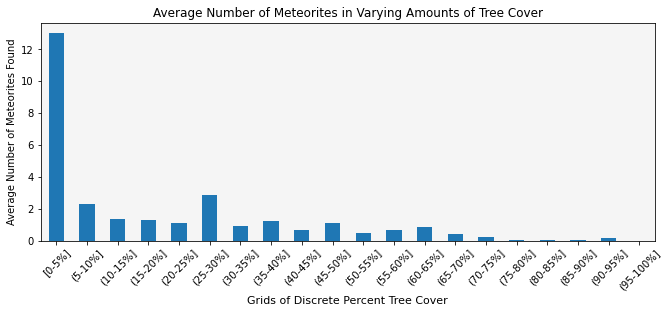

In [16]:
#plotting to see which percent tree cover boxes contain the most meteorites
fig, ax = plt.subplots(figsize=(11, 4))
df_final_bins['mean'].plot(kind='bar', ax=ax)
ax.set_title('Average Number of Meteorites in Varying Amounts of Tree Cover')
plt.xticks(rotation = 45)
ax.set_xlabel('Grids of Discrete Percent Tree Cover', fontsize=11)
ax.set_ylabel('Average Number of Meteorites Found', fontsize=10)
ax.set_facecolor('whitesmoke');

Although there is not a linear trend it is clear that the lowest vegetation bin has, by far, the highest meteorite count average!

## Density map of meteorites on vegetation

Using the meteorite counts, the original meteorite map figure can be improved. First, I'll add the meteorite count to the vegetation mean dataset. 

In [17]:
#adding met_count to vegetation dataset
veg_mean["meteorite_count"]=(['y', 'x'],  met_count)
veg_mean

<xarray.Dataset>
Dimensions:             (band: 1, y: 72, x: 144)
Coordinates:
  * band                (band) int64 1
  * x                   (x) float64 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * y                   (y) float64 88.75 86.25 83.75 ... -83.75 -86.25 -88.75
    spatial_ref         int64 0
Data variables:
    percent_tree_cover  (band, y, x) float32 nan nan nan nan ... 0.0 0.0 0.0 0.0
    meteorite_count     (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

Here I have made a function to find the number of meteorites found in the gridbox of a given meteorite landing location. To account for meteorites that lie on the edge of a gridbox, if the count is incorrectly assigned to zero, the meteorite location is 'pushed' into the correct box. I can then apply the function to the entire dataframe and create a new column of meteorite counts.

In [18]:
#function to find nearest abundance
def met_count_in_box(latitude, longitude):
    
    count = veg_mean.sel(x=longitude, y=latitude, method='nearest').meteorite_count.values #finding meteorite count
    
    if (count==0) & (np.isnan(latitude)==False) & (np.isnan(longitude)==False):            #to account for meteorites on the edge of a gridbox
        longitude = longitude + 0.1
        latitude  = latitude  - 0.1
        count = veg_mean.sel(x=longitude, y=latitude, method='nearest').meteorite_count.values
        
    return count

In [19]:
df['met_count'] =  df.apply(lambda row: met_count_in_box(row['reclat'], row['reclong']), axis = 1)

Now I can improve the figure! Instead of setting the markers to be transparent I will use the new 'meteorite count' column to color the markers. 

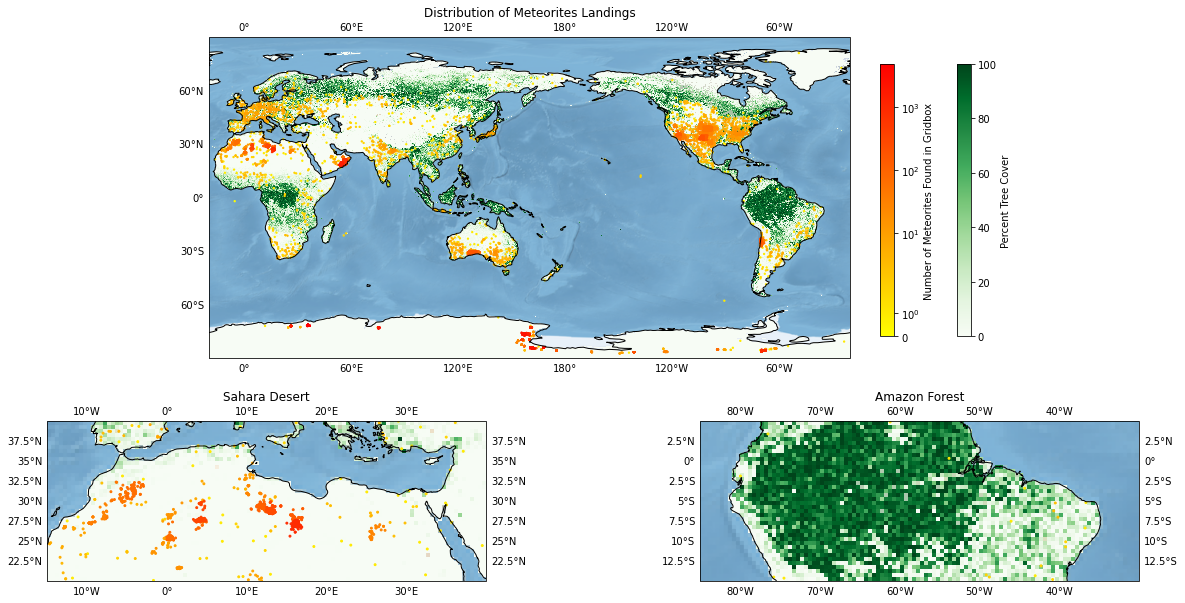

In [20]:
#improved figure!
fig  = plt.figure(figsize=(20, 10))
proj = ccrs.PlateCarree(central_longitude=160)

gs = fig.add_gridspec(8,9)
ax1 = fig.add_subplot(gs[0:4, 1:], projection=proj)
ax2 = fig.add_subplot(gs[3:, 1:4], projection=proj)
ax3 = fig.add_subplot(gs[3:, 5:8], projection=proj)

#global plot
ax1.coastlines()
ax1.stock_img()
ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)

vegetation = veg_masked['percent_tree_cover'].plot(ax=ax1, cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False)
veg_cb     = plt.colorbar(vegetation, ax=ax1, location='right', label='Percent Tree Cover', shrink=.85, anchor=(-0.9, 0.45))

df_sorted = df.sort_values('met_count')
meteorites = ax1.scatter(df_sorted.reclong, df_sorted.reclat, c=df_sorted.met_count, marker='.', label='Meteorite Landings'
                        , cmap='autumn_r', norm=matplotlib.colors.SymLogNorm(linthresh=3, vmin=df_sorted.met_count.min(), vmax=df_sorted.met_count.max()), 
                         transform=ccrs.PlateCarree(), s=7)
met_cb = plt.colorbar(meteorites, ax=ax1, location='right', label='Number of Meteorites Found in Gridbox', shrink=.85, anchor=(-0.15, 0.45))

#sahara subplot
veg_sahara = veg_masked.rio.clip_box(minx=-15, miny=20, maxx=40, maxy=40)
vegetation_sahara = veg_sahara['percent_tree_cover'].plot(ax=ax2, cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False)

met_sahara = df_sorted[(df_sorted.reclong>=-15) & (df_sorted.reclong<=40) & (df_sorted.reclat<=40) & (df_sorted.reclat>=20)]
meteorites_sahara = ax2.scatter(met_sahara.reclong, met_sahara.reclat, c=met_sahara.met_count, marker='.', label='Meteorite Landings', 
                                cmap='autumn_r' , norm=matplotlib.colors.SymLogNorm(linthresh=3, vmin=df_sorted.met_count.min(), vmax=df_sorted.met_count.max()),
                                transform=ccrs.PlateCarree(), s=15)

ax2.coastlines()
ax2.stock_img()
ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)


#amazon subplot
veg_amazon = veg_masked.rio.clip_box(minx=-85, miny=-15, maxx=-30, maxy=5)
vegetation_amazon = veg_amazon['percent_tree_cover'].plot(ax=ax3, cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False)

met_amazon = df_sorted[(df_sorted.reclong>=-85) & (df_sorted.reclong<=-30) & (df_sorted.reclat<=5) & (df_sorted.reclat>=-15)]
meteorites_sahara = ax3.scatter(met_amazon.reclong, met_amazon.reclat, c=met_amazon.met_count, marker='.', label='Meteorite Landings',
                                cmap='autumn_r', norm=matplotlib.colors.SymLogNorm(linthresh=3, vmin=df_sorted.met_count.min(), vmax=df_sorted.met_count.max()), 
                                transform=ccrs.PlateCarree(), s=15)

ax3.coastlines()
ax3.stock_img()
ax3.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)

#setting title
ax1.set_title('Distribution of Meteorites Landings')
ax2.set_title('Sahara Desert')
ax3.set_title('Amazon Forest')
fig.tight_layout();

This more accurately displays the density of meteorites found and reveals the locations with the highest counts to be in Antarctica, Oman, and the Sahara desert. Also, note, in Antarctica, where some of the highest abundaces are found, the locations of the meteorites 'landings' are not well distributed, but rather condensed to a few regions. This is due to the accumulation of meteorites in the ice over long periods of time and the subsequent movement of the glaciers that concentrate the meteorites to several areas.

## How many meteorites do we loose to the Amazon? or the ocean? (_rough_ estimate)

Now that it is clear that meteorites are much less likely to be found in regions with high vegetation, I'm curious how many meteorites have fallen in densely vegetated area, such as the amazon rainforest, and not been found. I decided to estimate this using two methods. To begin the first rough estimation I will select two bands of latitude with relatively low vegetation/high meteorite counts (latitudes: 20&deg; - 40&deg; N and S). I will assume these to be representative of the 'true' distribution of meteorite landings, so I will take the average of both values to get the global distribution. 

In [21]:
#calculating # meteorite/# of pixels with land
veg_nband = veg_masked.rio.clip_box(minx=veg_masked.x.min(), miny=20, maxx=veg_masked.x.max(), maxy=40)
veg_sband = veg_masked.rio.clip_box(minx=veg_masked.x.min(), miny=-40, maxx=veg_masked.x.max(), maxy=-20)

nband_land_pixels = len(veg_nband.percent_tree_cover.values[(np.isnan(veg_nband.percent_tree_cover.values)==False)])
sband_land_pixels = len(veg_sband.percent_tree_cover.values[(np.isnan(veg_sband.percent_tree_cover.values)==False)])

nband_metcount = df[(df.reclat<=40) & (df.reclat>=20)].id.count()
sband_metcount = df[(df.reclat<=-20) & (df.reclat>=-40)].id.count()

nband_met_per_land = nband_metcount/nband_land_pixels
sband_met_per_land = sband_metcount/sband_land_pixels
avg_met_per_land   = np.mean([nband_met_per_land, sband_met_per_land])

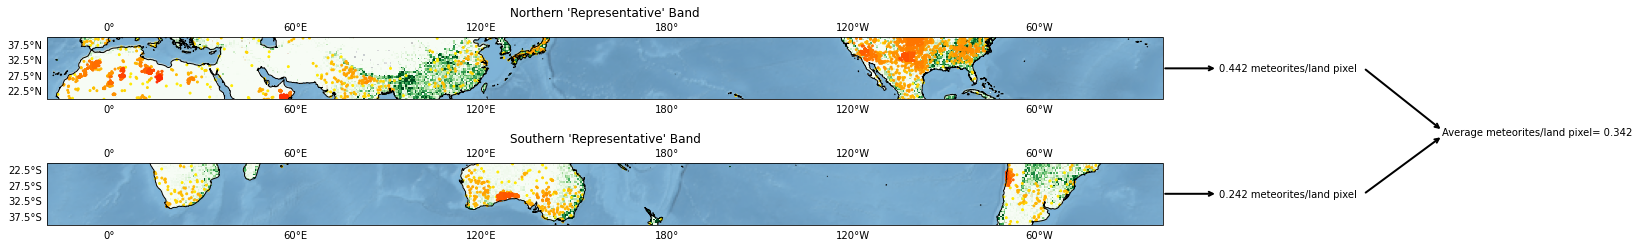

In [22]:
#visual representation  
fig  = plt.figure(figsize=(20, 10))
proj = ccrs.PlateCarree(central_longitude=160)

gs = fig.add_gridspec(2,1, hspace=-0.7, wspace=-0.7)
ax1 = fig.add_subplot(gs[0, :], projection=proj)
ax2 = fig.add_subplot(gs[1, :], projection=proj)

#northern subplot
vegetation_nband = veg_nband['percent_tree_cover'].plot(ax=ax1, cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False)

met_nband = df_sorted[(df_sorted.reclong>=veg_masked.x.values.min()) & (df_sorted.reclong<=veg_masked.x.values.max()) & (df_sorted.reclat<=40) & (df_sorted.reclat>=20)]
meteorites_nband = ax1.scatter(met_nband.reclong, met_nband.reclat, c=met_nband.met_count, marker='.', label='Meteorite Landings', 
                                cmap='autumn_r' , norm=matplotlib.colors.SymLogNorm(linthresh=3, vmin=df_sorted.met_count.min(), vmax=df_sorted.met_count.max()),
                                transform=ccrs.PlateCarree(), s=15)

ax1.annotate(str(np.round(nband_met_per_land, 3)) + ' meteorites/land pixel', xy=(1, 0.5), xycoords='axes fraction', xytext=(1.05, 0.5),
             arrowprops=dict(arrowstyle="<-", lw=2, color='k'), va='center')
ax1.annotate('', xy=(1.18, 0.5), xycoords='axes fraction', xytext=(1.25, -.5), 
             arrowprops=dict(arrowstyle="<-", lw=2, color='k'), va='center', ha='left')

ax1.coastlines()
ax1.stock_img()
ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)

#southern subplot
vegetation_sband= veg_sband['percent_tree_cover'].plot(ax=ax2, cmap='Greens', transform=ccrs.PlateCarree(), add_colorbar=False)

met_sband = df_sorted[(df_sorted.reclong>=veg_masked.x.values.min()) & (df_sorted.reclong<=veg_masked.x.values.max()) & (df_sorted.reclat<=-20) & (df_sorted.reclat>=-40)]
meteorites_sband = ax2.scatter(met_sband.reclong, met_sband.reclat, c=met_sband.met_count, marker='.', label='Meteorite Landings', 
                                cmap='autumn_r' , norm=matplotlib.colors.SymLogNorm(linthresh=3, vmin=df_sorted.met_count.min(), vmax=df_sorted.met_count.max()),
                                transform=ccrs.PlateCarree(), s=15)

ax2.annotate(str(np.round(sband_met_per_land, 3)) + ' meteorites/land pixel', xy=(1, 0.5), xycoords='axes fraction', xytext=(1.05, 0.5),
             arrowprops=dict(arrowstyle="<-", lw=2, color='k'), va='center')
ax2.annotate('', xy=(1.18, 0.5), xycoords='axes fraction', xytext=(1.25, 1.43), 
             arrowprops=dict(arrowstyle="<-", lw=2, color='k'), va='center')
ax2.text(270, -11, 'Average meteorites/land pixel= '+str(np.round(avg_met_per_land, 3)), )

ax2.coastlines()
ax2.stock_img()
ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)

#titles
ax1.set_title("Northern 'Representative' Band")
ax2.set_title("Southern 'Representative' Band");


Now that that the 'average global distrubution' is calculated I can make an estimate for how many meteorites have fallen in the Amazon forest and not been found. Additionally, considering the earth is mostly covered by water, I think it is also interesting to estimate the number of meteorites that have been lost by landing in the ocean.  

In [23]:
#calculating number of meteorites lost in amazon
veg_amazon_forest      = veg_masked.rio.clip_box(minx=-82, miny=-15, maxx=-45, maxy=8) #selection of amazon forest region
veg_amazon_forest_land = len(veg_amazon_forest.percent_tree_cover.values[(np.isnan(veg_amazon_forest.percent_tree_cover.values)==False)]) #choosing only land pixels
amazon_met_lost        = veg_amazon_forest_land * avg_met_per_land
print('Approx. Number of Meteorites Lost in Amazon Rainforest: ', amazon_met_lost.round(0))

Approx. Number of Meteorites Lost in Amazon Rainforest:  965.0


In [24]:
#calculating number of meteorites lost to the ocean
ocean_pixels   = len(veg_masked.percent_tree_cover.values[(np.isnan(veg_masked.percent_tree_cover.values)==True)]) #selecting all ocean pixels
ocean_met_lost = ocean_pixels * avg_met_per_land
print('Approx. Number of Meteorites Lost to Ocean: ', ocean_met_lost.round(0))

Approx. Number of Meteorites Lost to Ocean:  59787.0


For the second calculation method, I used the average meteorites per box for the bin with the lowest percent tree cover (0%-5%) as the 'global distribution'. Below is a visual representation of the gridboxes used.

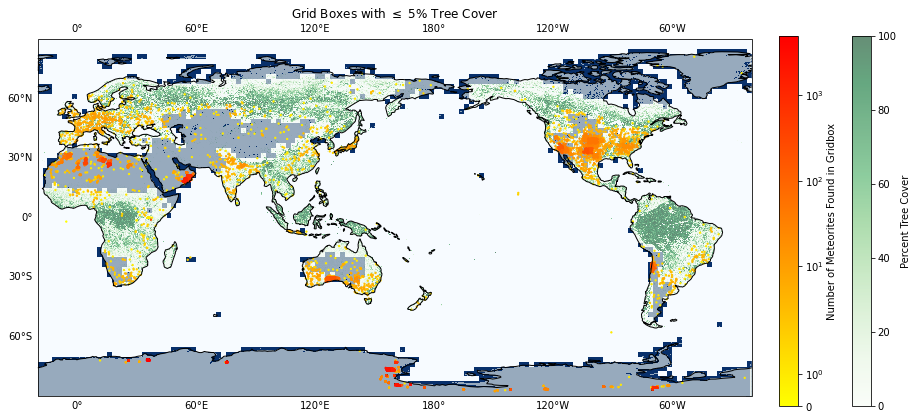

In [25]:
fig= plt.figure(figsize=(20, 8))
proj = ccrs.PlateCarree(central_longitude=160)
ax = plt.axes(projection=proj)

ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0)

five_per_veg= (veg_mean.percent_tree_cover) <= 5
five_per_veg.plot(transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Blues')

vegetation    = veg_masked['percent_tree_cover'].plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Greens', alpha=0.6)
vegetation_cb = plt.colorbar(vegetation, ax=ax, location='right', label='Percent Tree Cover', shrink=0.85, anchor=(-0.9, 0.45))

df_sorted = df.sort_values('met_count')
meteorites = ax.scatter(df_sorted.reclong, df_sorted.reclat, c=df_sorted.met_count, marker='.', label='Meteorite Landings'
                        , cmap='autumn_r', norm=matplotlib.colors.SymLogNorm(linthresh=3, vmin=df_sorted.met_count.min(), vmax=df_sorted.met_count.max()), 
                         transform=ccrs.PlateCarree(), s=7)
met_cb = plt.colorbar(meteorites, ax=ax, location='right', label='Number of Meteorites Found in Gridbox', shrink=.85, anchor=(-0.15, 0.45))



ax.set_title('Grid Boxes with $\leq$ 5% Tree Cover');

In [26]:
met_per_box_low_veg = df_final_bins['mean'][0]

In [27]:
veg_amazon_forest_2      = veg_mean.rio.clip_box(minx=-82, miny=-15, maxx=-45, maxy=8) #selection of amazon forest region
veg_amazon_forest_land_2 = len(veg_amazon_forest_2.percent_tree_cover.values[(np.isnan(veg_amazon_forest_2.percent_tree_cover.values)==False)])
amazon_met_lost2 = veg_amazon_forest_land_2 * met_per_box_low_veg
print('Approx. Number of Meteorites Lost in Amazon Rainforest: ', amazon_met_lost2.round(0))


Approx. Number of Meteorites Lost in Amazon Rainforest:  1730.0


In [28]:
ocean_boxes = len(veg_mean.percent_tree_cover.values[(np.isnan(veg_mean.percent_tree_cover.values)==True)])
ocean_met_lost_2 = ocean_boxes * met_per_box_low_veg
print('Approx. Number of Meteorites Lost to Ocean: ', ocean_met_lost_2.round(0))

Approx. Number of Meteorites Lost to Ocean:  79462.0


Although slightly higher, this method resulted in relatively similar estimates for the number of meteorites lost in the Amazon rainforest and the ocean.

## Conclusion

By applying a grid to the meteorite landing and vegetation datasets and taking counts/averages I was able to show that, on average, more meteorites are found in areas of lower vegetaion (i.e. $\leq$ 5% tree cover). Using these calculated values I also improved the visualization of the distribution of meteorite landings. Additionally, I estimated the number of meteorites lost in a highly vegetated area, such as the Amazon rainforest, and found that this number could be as high as 1,730 meteorites!